In [1]:
#Qiskit includes
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute
from qiskit import Aer
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise.errors.readout_error import *
from qiskit.circuit import Instruction
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,
                                                 CompleteMeasFitter, 
                                                 MeasurementFilter)
#Other python tools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.lines as mlines

## Setup Unfolding Methods

see https://arxiv.org/abs/1910.00129

In [2]:
def MatrixInversion(ymes,Rin):
    #Rin is a matrix where the first coordinate is the measured value and the second coordinate is the true value.
    return np.ravel(np.matmul(np.linalg.inv(np.matrix(Rin)),ymes))

def fun(x,ymes,Rin):
    mat_dot_x = np.ravel(np.matmul(Rin,x))
    return sum((ymes - mat_dot_x)**2)

def Ignis(ymes,Rin):
    #Rin is a matrix where the first coordinate is the measured value and the second coordinate is the true value.
    #This is copied from https://github.com/Qiskit/qiskit-ignis/blob/master/qiskit/ignis/mitigation/measurement/filters.py
    x0 = np.random.rand(len(ymes))
    x0 = x0 / sum(x0)
    nshots = sum(ymes)
    cons = ({'type': 'eq', 'fun': lambda x: nshots - sum(x)})
    bnds = tuple((0, nshots) for x in x0)
    res = minimize(fun, x0, method='SLSQP',constraints=cons, bounds=bnds, tol=1e-6, args=(ymes,Rin))
    return res.x

def IBU(ymes,t0,Rin,n):
    #This is the iterative Bayesian unfolding method.
    #Rin is a matrix where the first coordinate is the measured value and the second coordinate is the true value.
    #n is the number of iterations.
    
    tn = t0
    for q in range(n):
        out = []
        for j in range(len(t0)):
            mynum = 0.
            for i in range(len(ymes)):
                myden = 0.
                for k in range(len(t0)):
                    myden+=Rin[i][k]*tn[k]
                    pass
                mynum+=Rin[i][j]*tn[j]*ymes[i]/myden
                pass
            out+=[mynum]
        tn = out
        pass
    '''
    tn = t0
    for i in range(n):
        Rjitni = [np.array(Rin[:][i])*tn[i] for i in range(len(tn))]
        Pm_given_t = Rjitni / np.matmul(Rin,tn)
        tn = np.dot(Pm_given_t,ymes)
        pass
    '''
    return tn

## Useful functions for converting between bitstrings and integers

In [3]:
def mybin(input,q,r=1):
  if (r==0):
    return bin(input).split('b')[1].zfill(q) 
  else:
    return bin(input).split('b')[1].zfill(q)[::-1]

nqubits = 5

xvals = []
xlabs = []
xlabs0 = []
for i in range(2**nqubits):
    xvals+=[i]
    xlabs+=[r'$|'+mybin(i,nqubits)+r'\rangle$']
    xlabs0+['']
    pass

## Let's study the IBM Q Tokyo response matrix.

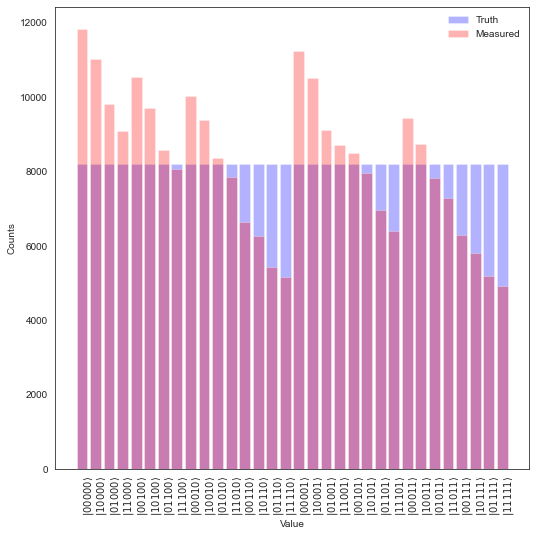

In [4]:
nqbits = 5
bin_convert = {}
for i in range(2**nqbits):
  bin_convert[bin(i).split('b')[1].zfill(nqbits)]=i
  pass

measured = np.zeros(2**nqbits)
truth = np.zeros(2**nqbits)
response = np.zeros((2**nqbits,2**nqbits))

for i in range(2**nqbits):
  myfile = open("output_gLR0_Tokyo_Unfold.dat")
  for line in myfile:
    if "Unfold_1" in line:
      myline = line.split("}")[i].split(",")
      for j in myline:
        if ":" not in j:
          continue
        outbin = 0
        counts = 0
        if "{" in j:
          outbin = int(bin_convert[j.split("{")[len(j.split("{"))-1].split(":")[0].split("'")[1]])
          counts = int(j.split("{")[len(j.split("{"))-1].split(":")[1])
        else:
          outbin = int(bin_convert[j.split(":")[0].split("'")[1]])
          counts = int(j.split(":")[1])
          pass
        truth[i] += counts
        measured[outbin] += counts
        response[outbin,i] += counts
        pass
      pass
    pass
  pass

sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
plt.bar(range(2**nqbits),truth,alpha=0.3,color='b',label='Truth')
plt.bar(range(2**nqbits),measured,alpha=0.3,color='r',label='Measured')
xvals = []
xlabs = []
for i in range(2**nqbits):
  xvals+=[i+0.5]
  xlabs+=[r'$|'+mybin(i,nqbits)+r'\rangle$']
  pass
plt.xticks(xvals,xlabs,rotation='vertical',size=10)
plt.ylabel("Counts")
plt.xlabel("Value")
plt.legend(frameon=False,loc='upper right')

## Fig. 2a

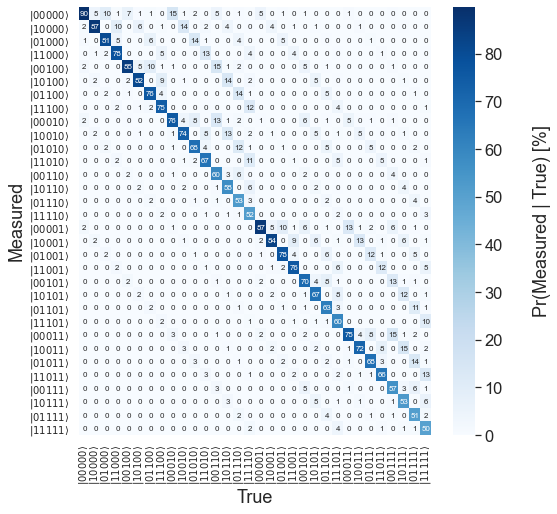

In [5]:
response_normalized = np.zeros((2**nqbits,2**nqbits))
response_normalized_reversed = np.zeros((2**nqbits,2**nqbits))
response_labels = np.zeros((2**nqbits,2**nqbits))
for i in range(2**nqbits):
  mysum = 0.
  for j in range(2**nqbits):
    mysum+=response[j,i]
    pass
  for j in range(2**nqbits):
    response_labels[j][i] = '0'
    if (mysum > 0):
      response_normalized[j,i] = 100.*response[j,i]/mysum
      response_normalized_reversed[i,j] = response_normalized[j,i]
      response_labels[j][i] = '%1.0f' % (response_normalized[j,i])
      pass
    pass
  pass

f = plt.figure(figsize=(8.5, 8.5))
sns.set(font_scale=1.5)
ax = sns.heatmap(response_normalized,annot=response_labels,annot_kws={"size": 8},cmap="Blues")
ax.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax.collections[0].colorbar
cbar.set_label('Pr(Measured | True) [%]', labelpad=30)
plt.xticks(xvals,xlabs,rotation='vertical',fontsize=10)
plt.yticks(xvals,xlabs,rotation='horizontal',fontsize=10)
plt.xlabel('True',fontsize=18)
plt.ylabel('Measured',fontsize=18)
plt.subplots_adjust(bottom=0.18,left=0.18)

In [6]:
diagonal = [response_normalized[i][i] for i in range(2**5)]
numb0s = [xlabs[i].count("0") for i in range(2**5)]

Text(0.5, 0, 'Pr(measure correct string)')

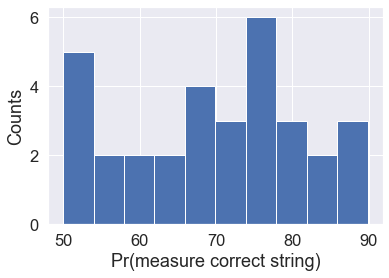

In [7]:
plt.hist(diagonal)
plt.ylabel("Counts")
plt.xlabel("Pr(measure correct string)")

## Fig. 2b

Text(0, 0.5, 'Pr(measure correct string)')

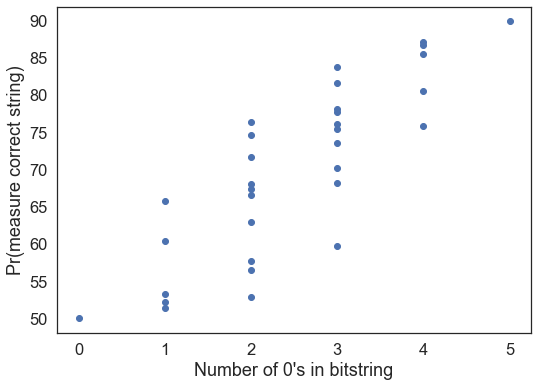

In [32]:
sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
gs = GridSpec(2, 1, width_ratios=[1], height_ratios=[3.5, 1])
ax1 = plt.subplot(gs[0])
plt.scatter(numb0s,diagonal)
plt.xlabel("Number of 0's in bitstring")
plt.ylabel("Pr(measure correct string)")
#plt.savefig("scalingwith1sinstrings.pdf",bbox_inches='tight')

## Implement the IBM Q Tokyo readout errors

In [33]:
nqubits_r = 5

nqubitarray_r = []
for i in range(nqubits_r):
    nqubitarray_r+=[i]
    pass 

mynoise_r = []
for i in range(2**nqubits_r):
    hold = []
    for j in range(2**nqubits_r):
        #if (i==j):
        #    hold+=[1.]
        #else:
        #    hold+=[0.]
        hold+=[response_normalized[j][i]/100.]
        pass
    mynoise_r+=[hold]
    pass
c_r = ReadoutError(mynoise_r)
noise_model_r = noise.NoiseModel()
noise_model_r.add_readout_error(c_r,nqubitarray_r)

In [34]:
#This is a special measure function that allows us to simultaneously measure multiple qubits at the same time.
measure2_r = Instruction("measure", nqubits_r, nqubits_r, [])

n = 100000

simulator_r = Aer.get_backend('qasm_simulator')

#Calibration circuit
meas_cals_mine_r = []
for i in range(2**nqubits_r):
    binnumber_initial = mybin(i,nqubits_r)
    qr_r = QuantumRegister(nqubits_r, 'qr')
    cr_r = ClassicalRegister(nqubits_r, 'cr')
    circ_r = QuantumCircuit(qr_r, cr_r)
    for j in range(nqubits_r):
        if (binnumber_initial[j]=='1'):
            circ_r.x(qr_r[j])
            pass
        pass
    pass
    circ_r.name='cal_'+binnumber_initial[::-1] #Their convention is backwards of mine.
    circ_r.name=circ_r.name
    circ_r.append(measure2_r, nqubitarray_r, nqubitarray_r)
    meas_cals_mine_r+=[circ_r]
    pass

#Vector for state labels.
state_labels_r = []
for i in range(2**nqubits_r):
    state_labels_r += [mybin(i,nqubits_r)]
    pass

#These are our custom calibration circuits.
job_r = execute(meas_cals_mine_r, backend=simulator_r, shots=int(n/(2**nqubits_r)), noise_model=noise_model_r)
cal_results_r = job_r.result()
meas_fitter_r = CompleteMeasFitter(cal_results_r, state_labels_r)
meas_filter_r = meas_fitter_r.filter


#Let's first quickly process these
many_counts_r = []
for i in range(2**nqubits_r):
    binnumber_initial = mybin(i,nqubits_r)
    counts_r = cal_results_r.get_counts(meas_cals_mine_r[i])
    many_counts_r+=[counts_r]
    pass

#Let's make our own matrix based on cal_results.
measured_cal_r = np.zeros(2**nqubits_r)
truth_cal_r = np.zeros(2**nqubits_r)
response_cal_r = np.zeros((2**nqubits_r,2**nqubits_r))
for j in range(len(many_counts_r)):
    counts = many_counts_r[j]
    for i in range(2**nqubits_r):
        binnumber_initial = mybin(i,nqubits_r,0)
        if (binnumber_initial in counts):
            measured_cal_r[i]+=counts[binnumber_initial]
            truth_cal_r[j]+=counts[binnumber_initial]
            response_cal_r[i,j]+=counts[binnumber_initial]
            pass
        pass
    pass
response_normalized_cal_r = np.zeros((2**nqubits_r,2**nqubits_r))
for i in range(len(truth_cal_r)):
    for j in range(len(truth_cal_r)):
        response_normalized_cal_r[i,j]=response_cal_r[i,j]/truth_cal_r[j]
        pass
    pass

## Example 1: W state

In [35]:
#Implementation from https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/w_state/W%20State%201%20-%20Multi-Qubit%20Systems.ipynb

# Here, two useful routine
# Define a F_gate
def F_gate(circ,q,i,j,n,k) :
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    circ.ry(-theta,q[j])       
    circ.cz(q[i],q[j])
    circ.ry(theta,q[j])
    circ.barrier(q[i])
# Define the cxrv gate which uses reverse CNOT instead of CNOT
def  cxrv(circ,q,i,j) :
    circ.h(q[i])
    circ.h(q[j])
    circ.cx(q[j],q[i])
    circ.h(q[i])
    circ.h(q[j])
    circ.barrier(q[i],q[j])
    
# 5-qubit W state
nq = 5
q = QuantumRegister(nq) 
c = ClassicalRegister(nq)
W_states = QuantumCircuit(q,c) 

W_states.x(q[4]) #start is |10000>
F_gate(W_states,q,4,3,5,1) # Applying F12
F_gate(W_states,q,3,2,5,2) # Applying F23
F_gate(W_states,q,2,1,5,3) # Applying F34
F_gate(W_states,q,1,0,5,4) # Applying F45
W_states.cx(q[3],q[4]) # cNOT 21
cxrv(W_states,q,2,3)   # cNOT 32
W_states.cx(q[1],q[2]) # cNOT 43
W_states.cx(q[0],q[1]) # cNOT 54 
for i in range(5) : #Inverted W state
    W_states.x([q[i]])
W_states.append(measure2_r, nqubitarray_r, nqubitarray_r)

In [36]:
W_states_nominal = QuantumCircuit(q,c) 

W_states_nominal.x(q[4]) #start is |10000>
F_gate(W_states_nominal,q,4,3,5,1) # Applying F12
F_gate(W_states_nominal,q,3,2,5,2) # Applying F23
F_gate(W_states_nominal,q,2,1,5,3) # Applying F34
F_gate(W_states_nominal,q,1,0,5,4) # Applying F45
W_states_nominal.cx(q[3],q[4]) # cNOT 21
cxrv(W_states_nominal,q,2,3)   # cNOT 32
W_states_nominal.cx(q[1],q[2]) # cNOT 43
W_states_nominal.cx(q[0],q[1]) # cNOT 54 
W_states_nominal.append(measure2_r, nqubitarray_r, nqubitarray_r)

In [37]:
#Now, for the actual measurement

counts_true = execute(W_states, simulator_r, shots=n).result().get_counts()
counts_test = execute(W_states, simulator_r, shots=n, noise_model=noise_model_r).result().get_counts()

#Making the truth_test_r and measured_test_r here.
truth_test_r = np.zeros(2**nqubits_r)
measured_test_r = np.zeros(2**nqubits_r)

for i in range(2**nqubits_r):
    binnumber_initial = mybin(i,nqubits_r,0)
    truth_test_r[i] = 0
    measured_test_r[i] = 0
    if (binnumber_initial in counts_true):
        truth_test_r[i]+=counts_true[binnumber_initial]
    if (binnumber_initial in counts_test):
        measured_test_r[i]+=counts_test[binnumber_initial]

In [38]:
#Now, for the unfolding.
unfolded_IBU_r = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100)

## Fig. 3

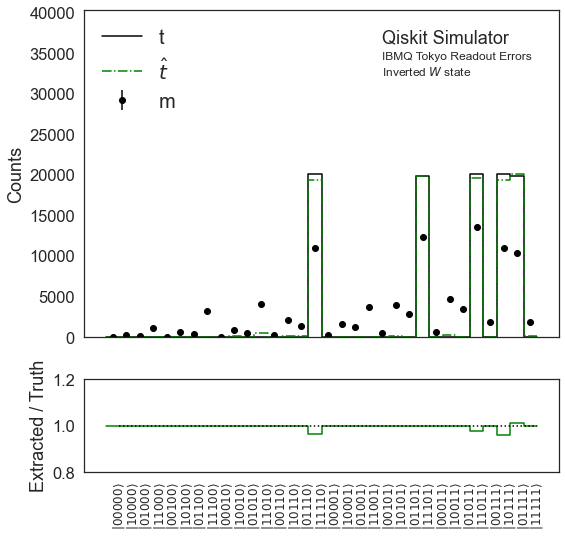

In [48]:
def myre(x):
    return np.concatenate([[x[0]],x])

bincenters_r = np.array(xvals)+0.5
sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
gs = GridSpec(2, 1, width_ratios=[1], height_ratios=[3.5, 1])
ax1 = plt.subplot(gs[0])
ax1.set_xticklabels( () )

mybincenters = np.linspace(-0.5,31.5,33)
plt.step(mybincenters,myre(truth_test_r),color='black',label=r"t")
plt.errorbar(0.5*(mybincenters[1:]+mybincenters[:-1]),measured_test_r,yerr=np.sqrt(measured_test_r),label='m',marker='o',linestyle='none',color='black')
plt.step(mybincenters,myre(unfolded_IBU_r),color='green',linestyle='-.',label=r"$\hat{t}$")

_=plt.xticks(xvals,xlabs0,rotation='vertical',fontsize=10)
plt.ylabel('Counts')
plt.ylim([0,2.*max(truth_test_r)])
plt.legend(loc='upper left',fontsize=20,frameon=False)
_=plt.text(20., max(truth_test_r)*1.8, "Qiskit Simulator", fontsize=18)
_=plt.text(20., max(truth_test_r)*1.7, "IBMQ Tokyo Readout Errors", fontsize=12)
_=plt.text(20., max(truth_test_r)*1.6, "Inverted $W$ state", fontsize=12)

ax2 = plt.subplot(gs[1])
ratio_ignis2_r = np.zeros(2**nqubits_r)
ratio_ignis_r = np.zeros(2**nqubits_r)
ratio_measured_r = np.zeros(2**nqubits_r)
ratio_unfold_r = np.zeros(2**nqubits_r)
for i in range(len(ratio_unfold_r)):
    ratio_unfold_r[i]=1.
    if (truth_test_r[i] > 0):
        ratio_unfold_r[i] = unfolded_IBU_r[i]/truth_test_r[i]
        pass
    if (ratio_measured_r[i] > 0):
        ratio_measured_r[i] = measured_test_r[i]/truth_test_r[i]
    pass

plt.ylim([0.8,1.2])
plt.step(mybincenters,myre(ratio_unfold_r),color='green')
#plt.step(mybincenters,myre(ratio_measured_r),color='black')
plt.ylabel('Extracted / Truth')
xx2 = [1.,1.]
plt.plot([xvals[0],xvals[len(xvals)-1]],xx2,color='black',linestyle=':')
_=plt.xticks(xvals,xlabs,rotation='vertical',fontsize=12)
#plt.savefig("InvertedWState.pdf",bbox_inches='tight')

## Readout Rebalancing Methods

In [60]:
def rebalance_method1(input_circuit,nominal_result,nq):
    # This method minimizes the average number of 1's in the output.
    # input_circuit is the input circuit
    # nominal_result is a (small) sample of the result that has been unfolded to get a sense for the balance of 0's and 1's.
    # nq is the number of qubits (could also just extract this from the circuit).    
    
    #CURRENTLY ONLY WORKS FOR nq=5.  Need to make the set of for loops below recursive to get the general case.
    
    xlabs_hold = []
    for i in range(2**nq):
        xlabs_hold+=[r'$|'+mybin(i,nq)+r'\rangle$']
        pass    
    
    mymin = 2**nq+1
    swaps = []
    for q0 in [0,1]:
        for q1 in [0,1]:
            for q2 in [0,1]:
                for q3 in [0,1]:
                    for q4 in [0,1]:
                        xlabs_hold = xlabs.copy()
                        for j in range(len(xlabs_hold)):
                            xlabs_hold[j] = list(xlabs_hold[j])
                            if q0==1:
                                xlabs_hold[j][2]=str(1-int(xlabs_hold[j][2]))
                            if q1==1:
                                xlabs_hold[j][3]=str(1-int(xlabs_hold[j][3]))
                            if q2==1:
                                xlabs_hold[j][4]=str(1-int(xlabs_hold[j][4]))
                            if q3==1:
                                xlabs_hold[j][5]=str(1-int(xlabs_hold[j][5]))
                            if q4==1:
                                xlabs_hold[j][6]=str(1-int(xlabs_hold[j][6]))
                            xlabs_hold[j] = "".join(xlabs_hold[j])
                            pass
                        numb1s_hold = [xlabs_hold[i].count("1") for i in range(2**nq)]
                        val = sum(np.array(nominal_result)*np.array(numb1s_hold))/sum(nominal_result)
                        if (val < mymin):
                            mymin = val
                            swaps = [q0,q1,q2,q3,q4]

    input_circuit_modified = input_circuit.copy()
    input_circuit_modified.data.pop(len(input_circuit_modified)-1) #remove the measure so we can add x gates
    for i in range(len(swaps)):
        if (swaps[i]==1):
            input_circuit_modified.x(i) 
    input_circuit_modified.append(measure2_r, nqubitarray_r, nqubitarray_r) #add back the measure 
    return input_circuit_modified,swaps

In [61]:
def rebalance_method2(input_circuit,nominal_result,nq):
    # This method swaps a qubit if it is on average mostly in the 1 state.
    # input_circuit is the input circuit
    # nominal_result is a (small) sample of the result that has been unfolded to get a sense for the balance of 0's and 1's.
    # nq is the number of qubits (could also just extract this from the circuit).
    
    input_circuit_modified = input_circuit.copy()
    input_circuit_modified.data.pop(len(input_circuit_modified)-1) #remove the measure so we can add x gates

    xlabs_hold = []
    for i in range(2**nq):
        xlabs_hold+=[r'$|'+mybin(i,nq)+r'\rangle$']
        pass
    
    swaps = []
    for i in range(nq):
        myavg = 0.
        myavg_den = 0.
        for j in range(len(xlabs_hold)):
            myavg += nominal_result[j]*int(xlabs_hold[j][i+2])
            myavg_den+=nominal_result[j]
        if (myavg/myavg_den > 0.5): #this qubit is usually 1.
            input_circuit_modified.x(i) 
            swaps+=[1]
        else:
            swaps+=[0]
    input_circuit_modified.append(measure2_r, nqubitarray_r, nqubitarray_r) #add back the measure
    return input_circuit_modified,swaps

## A statistic to check

In [43]:
def mean_stat_uncert(input_circuit,swapmap,N=1000,nshots=100000):

    mymapping = {}
    for i in range(2**nqubits_r):
        mymapping[mybin(i,nqubits_r,0)] = i
    
    mymapping_inverse_r = {}
    for i in range(2**nqubits_r):
        mymapping_inverse_r[bin(i).split('b')[1].zfill(nq) ] = i
        pass
    
    hold = []
    for k in range(N):

        if (k%10==0):
            print("on i=",k)

        counts_test = execute(input_circuit, simulator_r, shots=nshots, noise_model=noise_model_r).result().get_counts()
        
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            measured_test_r[i] = 0
            if (binnumber_initial in counts_test):
                measured_test_r[i]+=counts_test[binnumber_initial]
        unfolded_IBU_r = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100) 
        
        unfolded_IBU_r_postswap = unfolded_IBU_r.copy()
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            #print(binnumber_initial)
            binnumber_initial = list(binnumber_initial)
            for j in range(nqubits_r):
                if (swapmap[j]==1):
                    binnumber_initial[-j-1] = str(1-int(binnumber_initial[-j-1])) #the convention here is backwards!
            binnumber_initial = "".join(binnumber_initial)  
            unfolded_IBU_r_postswap[mymapping[binnumber_initial]] = unfolded_IBU_r[i]
            pass
        
        #Now, let's compute the average value.
        myval = 0.
        myval_den = 0.
        for i in range(2**nqubits_r):
            myval+=unfolded_IBU_r_postswap[i]*mymapping_inverse_r[mybin(i,nqubits_r,0)]
            myval_den+=unfolded_IBU_r_postswap[i]
        #print(myval/myval_den)
        hold+=[myval/myval_den]
        pass
    return np.mean(hold),np.std(hold),hold

In [110]:
def mean_stat_uncert_Google(input_circuit,N=1000,nshots=100000):

    #First, construct the fully inverted circuit.
    
    input_circuit_inverted = input_circuit.copy()
    input_circuit_inverted.data.pop(len(input_circuit_inverted)-1) #remove the measure so we can add x gates
    for i in range(nqubits_r):
        input_circuit_inverted.x(i) 
    input_circuit_inverted.append(measure2_r, nqubitarray_r, nqubitarray_r) #add back the measure
    
    mymapping = {}
    for i in range(2**nqubits_r):
        mymapping[mybin(i,nqubits_r,0)] = i
    
    mymapping_inverse_r = {}
    for i in range(2**nqubits_r):
        mymapping_inverse_r[bin(i).split('b')[1].zfill(nq) ] = i
        pass
    
    hold = []
    for k in range(N):

        if (k%10==0):
            print("on i=",k)

        #First, the nominal circuit:
        counts_test = execute(input_circuit, simulator_r, shots=int(nshots/2), noise_model=noise_model_r).result().get_counts()
        
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            measured_test_r[i] = 0
            if (binnumber_initial in counts_test):
                measured_test_r[i]+=counts_test[binnumber_initial]
        unfolded_IBU_r = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100) 
        
        unfolded_IBU_r_postswap = unfolded_IBU_r.copy()
        swapmap=np.zeros(nqubits_r)
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            #print(binnumber_initial)
            binnumber_initial = list(binnumber_initial)
            for j in range(nqubits_r):
                if (swapmap[j]==1):
                    binnumber_initial[-j-1] = str(1-int(binnumber_initial[-j-1])) #the convention here is backwards!
            binnumber_initial = "".join(binnumber_initial)  
            unfolded_IBU_r_postswap[mymapping[binnumber_initial]] = unfolded_IBU_r[i]
            pass
        
        #Now, the inverted one:
        counts_test_inverted = execute(input_circuit_inverted, simulator_r, shots=int(nshots/2), noise_model=noise_model_r).result().get_counts()
        
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            measured_test_r[i] = 0
            if (binnumber_initial in counts_test_inverted):
                measured_test_r[i]+=counts_test_inverted[binnumber_initial]
        unfolded_IBU_r_inverted = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100) 
        
        unfolded_IBU_r_inverted_postswap = unfolded_IBU_r_inverted.copy()
        swapmap=np.ones(nqubits_r)
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            #print(binnumber_initial)
            binnumber_initial = list(binnumber_initial)
            for j in range(nqubits_r):
                if (swapmap[j]==1):
                    binnumber_initial[-j-1] = str(1-int(binnumber_initial[-j-1])) #the convention here is backwards!
            binnumber_initial = "".join(binnumber_initial)  
            unfolded_IBU_r_inverted_postswap[mymapping[binnumber_initial]] = unfolded_IBU_r_inverted[i]
            pass
        
        #Now, let's compute the average value.
        myval = 0.
        myval_den = 0.
        for i in range(2**nqubits_r):
            myval+=(unfolded_IBU_r_postswap[i]+unfolded_IBU_r_inverted_postswap[i])*mymapping_inverse_r[mybin(i,nqubits_r,0)]
            myval_den+=unfolded_IBU_r_postswap[i]+unfolded_IBU_r_inverted_postswap[i]
        #print(myval/myval_den)
        hold+=[myval/myval_den]
        pass
    return np.mean(hold),np.std(hold),hold

In [68]:
W_states_modified1,swapmap1 = rebalance_method1(W_states,unfolded_IBU_r,5)
W_states_modified2,swapmap2 = rebalance_method2(W_states,unfolded_IBU_r,5)
print(swapmap1,swapmap2)

[1, 1, 1, 1, 1] [1, 1, 1, 1, 1]


In [151]:
rerun = False
resave = False

if (rerun):
    mWg,sWg,hWg = mean_stat_uncert_Google(W_states)
    mWn,sWn,hWn = mean_stat_uncert(W_states,[0,0,0,0,0])
    mW,sW,hW = mean_stat_uncert(W_states_modified2,swapmap2)
    if (resave):
        np.save("files/WstateMeansStds",np.array([mWg,sWg,mWn,sWn,mW,sW]))
        np.save("files/WstateGoogle",np.array(hWg))
        np.save("files/WstateNominal",np.array(hWn))
        np.save("files/WstateRRB",np.array(hW))
else:
    mWg,sWg,mWn,sWn,mW,sW = np.load("files/WstateMeansStds.npy")
    hWg = np.load("files/WstateGoogle.npy")
    hWn = np.load("files/WstateNominal.npy")
    hW = np.load("files/WstateRRB.npy")

In [149]:
def mean_stat(in_vals):
    mystore = []
    for i in range(1000):
        hold = []
        for j in range(len(in_vals)):
            for k in range(np.random.poisson(1)):
                hold+=[in_vals[j]]
                pass
            pass
        mystore+=[np.mean(hold)]
        pass
    return(np.std(mystore)) #should be the same as std/\sqrt{n}

def std_stat(in_vals):
    mystore = []
    for i in range(1000):
        hold = []
        for j in range(len(in_vals)):
            for k in range(np.random.poisson(1)):
                hold+=[in_vals[j]]
                pass
            pass
        mystore+=[np.std(hold)]
        pass
    return(np.std(mystore))

In [152]:
print(mWg,"+/-",mean_stat(hWg)) #should be same as sWg*1000**-0.5
print(mWn,"+/-",mean_stat(hWn)) #should be same as sWn*1000**-0.5
print(mW,"+/-",mean_stat(hW)) #should be same as sW*1000**-0.5
print("\n")
print(sWg,"+/-",std_stat(hWg))
print(sWn,"+/-",std_stat(hWn))
print(sW,"+/-",std_stat(hW))

24.74725613272605 +/- 0.0006822316906035279
24.704741612746297 +/- 0.000700545034513245
24.794277639791606 +/- 0.0005842574948458055


0.021430310670331347 +/- 0.0005080999622971401
0.02319365580168688 +/- 0.0005170676756929435
0.018883629593656113 +/- 0.0003952355145799232


## Example 2: Grover search

In [46]:
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle
from qiskit import Aer
from qiskit.visualization import plot_histogram

In [47]:
expression = LogicalExpressionOracle("a & b & c & d & e") #Gives us a state of 11111 for our result.
expression.construct_circuit()
G = Grover(expression)

In [51]:
grover_nominal = Grover.construct_circuit(G, measurement = False)
cr = ClassicalRegister(5)
grover_nominal.add_register(cr)
grover_nominal.append(measure2_r, [0,1,2,3,4],[0,1,2,3,4])

In [56]:
#Now, for the actual measurement

counts_true = execute(grover_nominal, simulator_r, shots=n).result().get_counts()
counts_test = execute(grover_nominal, simulator_r, shots=n, noise_model=noise_model_r).result().get_counts()

#Making the truth_test_r and measured_test_r here.
truth_test_r = np.zeros(2**nqubits_r)
measured_test_r = np.zeros(2**nqubits_r)

for i in range(2**nqubits_r):
    binnumber_initial = mybin(i,nqubits_r,0)
    truth_test_r[i] = 0
    measured_test_r[i] = 0
    if (binnumber_initial in counts_true):
        truth_test_r[i]+=counts_true[binnumber_initial]
    if (binnumber_initial in counts_test):
        measured_test_r[i]+=counts_test[binnumber_initial]

In [57]:
#Now, for the unfolding.
unfolded_IBU_r = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100)

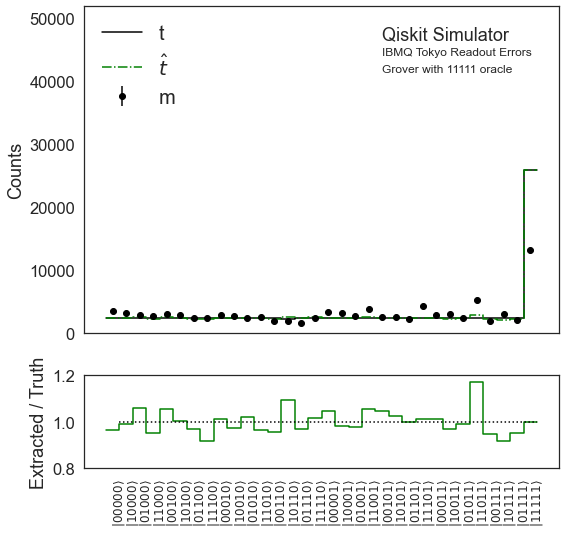

In [58]:
def myre(x):
    return np.concatenate([[x[0]],x])

bincenters_r = np.array(xvals)+0.5
sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
gs = GridSpec(2, 1, width_ratios=[1], height_ratios=[3.5, 1])
ax1 = plt.subplot(gs[0])
ax1.set_xticklabels( () )

mybincenters = np.linspace(-0.5,31.5,33)
plt.step(mybincenters,myre(truth_test_r),color='black',label=r"t")
plt.errorbar(0.5*(mybincenters[1:]+mybincenters[:-1]),measured_test_r,yerr=np.sqrt(measured_test_r),label='m',marker='o',linestyle='none',color='black')
plt.step(mybincenters,myre(unfolded_IBU_r),color='green',linestyle='-.',label=r"$\hat{t}$")

_=plt.xticks(xvals,xlabs0,rotation='vertical',fontsize=10)
plt.ylabel('Counts')
plt.ylim([0,2.*max(truth_test_r)])
plt.legend(loc='upper left',fontsize=20,frameon=False)
_=plt.text(20., max(truth_test_r)*1.8, "Qiskit Simulator", fontsize=18)
_=plt.text(20., max(truth_test_r)*1.7, "IBMQ Tokyo Readout Errors", fontsize=12)
_=plt.text(20., max(truth_test_r)*1.6, "Grover with 11111 oracle", fontsize=12)

ax2 = plt.subplot(gs[1])
ratio_ignis2_r = np.zeros(2**nqubits_r)
ratio_ignis_r = np.zeros(2**nqubits_r)
ratio_measured_r = np.zeros(2**nqubits_r)
ratio_unfold_r = np.zeros(2**nqubits_r)
for i in range(len(ratio_unfold_r)):
    ratio_unfold_r[i]=1.
    if (truth_test_r[i] > 0):
        ratio_unfold_r[i] = unfolded_IBU_r[i]/truth_test_r[i]
        pass
    if (ratio_measured_r[i] > 0):
        ratio_measured_r[i] = measured_test_r[i]/truth_test_r[i]
    pass

plt.ylim([0.8,1.2])
plt.step(mybincenters,myre(ratio_unfold_r),color='green')
#plt.step(mybincenters,myre(ratio_measured_r),color='black')
plt.ylabel('Extracted / Truth')
xx2 = [1.,1.]
plt.plot([xvals[0],xvals[len(xvals)-1]],xx2,color='black',linestyle=':')
_=plt.xticks(xvals,xlabs,rotation='vertical',fontsize=12)
plt.savefig("GroverState.pdf",bbox_inches='tight')

In [67]:
Grover_modified1,swapmap1 = rebalance_method1(grover_nominal,unfolded_IBU_r,5)
Grover_modified2,swapmap2 = rebalance_method2(grover_nominal,unfolded_IBU_r,5)
print(swapmap1,swapmap2)

[1, 1, 1, 1, 1] [1, 1, 1, 1, 1]


In [127]:
def highval_stat_uncert(input_circuit,swapmap,N=1000,nshots=100000):

    mymapping = {}
    for i in range(2**nqubits_r):
        mymapping[mybin(i,nqubits_r,0)] = i
    
    mymapping_inverse_r = {}
    for i in range(2**nqubits_r):
        mymapping_inverse_r[bin(i).split('b')[1].zfill(nq) ] = i
        pass
    
    hold = []
    for k in range(N):

        if (k%10==0):
            print("on i=",k)

        counts_test = execute(input_circuit, simulator_r, shots=nshots, noise_model=noise_model_r).result().get_counts()
        
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            measured_test_r[i] = 0
            if (binnumber_initial in counts_test):
                measured_test_r[i]+=counts_test[binnumber_initial]
        unfolded_IBU_r = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100) 
        
        unfolded_IBU_r_postswap = unfolded_IBU_r.copy()
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            #print(binnumber_initial)
            binnumber_initial = list(binnumber_initial)
            for j in range(nqubits_r):
                if (swapmap[j]==1):
                    binnumber_initial[-j-1] = str(1-int(binnumber_initial[-j-1])) #the convention here is backwards!
            binnumber_initial = "".join(binnumber_initial)  
            unfolded_IBU_r_postswap[mymapping[binnumber_initial]] = unfolded_IBU_r[i]
            pass
        
        #Now, let's compute the average value.
        myval = 0.
        for i in range(2**nqubits_r):
            print(i,unfolded_IBU_r_postswap[i])
            if (i!=2**nqubits_r-1):
                continue
            myval+=unfolded_IBU_r_postswap[i]
        hold+=[myval]
        pass
    return np.mean(hold),np.std(hold),hold

In [133]:
def highval_stat_uncert_Google(input_circuit,N=1000,nshots=100000):

    #First, construct the fully inverted circuit.
    
    input_circuit_inverted = input_circuit.copy()
    input_circuit_inverted.data.pop(len(input_circuit_inverted)-1) #remove the measure so we can add x gates
    for i in range(nqubits_r):
        input_circuit_inverted.x(i) 
    input_circuit_inverted.append(measure2_r, nqubitarray_r, nqubitarray_r) #add back the measure
    
    mymapping = {}
    for i in range(2**nqubits_r):
        mymapping[mybin(i,nqubits_r,0)] = i
    
    mymapping_inverse_r = {}
    for i in range(2**nqubits_r):
        mymapping_inverse_r[bin(i).split('b')[1].zfill(nq) ] = i
        pass
    
    hold = []
    for k in range(N):

        if (k%10==0):
            print("on i=",k)

        #First, the nominal circuit:
        counts_test = execute(input_circuit, simulator_r, shots=int(nshots/2), noise_model=noise_model_r).result().get_counts()
        
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            measured_test_r[i] = 0
            if (binnumber_initial in counts_test):
                measured_test_r[i]+=counts_test[binnumber_initial]
        unfolded_IBU_r = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100) 
        
        unfolded_IBU_r_postswap = unfolded_IBU_r.copy()
        swapmap=np.zeros(nqubits_r)
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            #print(binnumber_initial)
            binnumber_initial = list(binnumber_initial)
            for j in range(nqubits_r):
                if (swapmap[j]==1):
                    binnumber_initial[-j-1] = str(1-int(binnumber_initial[-j-1])) #the convention here is backwards!
            binnumber_initial = "".join(binnumber_initial)  
            unfolded_IBU_r_postswap[mymapping[binnumber_initial]] = unfolded_IBU_r[i]
            pass
        
        #Now, the inverted one:
        counts_test_inverted = execute(input_circuit_inverted, simulator_r, shots=int(nshots/2), noise_model=noise_model_r).result().get_counts()
        
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            measured_test_r[i] = 0
            if (binnumber_initial in counts_test_inverted):
                measured_test_r[i]+=counts_test_inverted[binnumber_initial]
        unfolded_IBU_r_inverted = IBU(measured_test_r,truth_cal_r,response_normalized_cal_r,100) 
        
        unfolded_IBU_r_inverted_postswap = unfolded_IBU_r_inverted.copy()
        swapmap=np.ones(nqubits_r)
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            #print(binnumber_initial)
            binnumber_initial = list(binnumber_initial)
            for j in range(nqubits_r):
                if (swapmap[j]==1):
                    binnumber_initial[-j-1] = str(1-int(binnumber_initial[-j-1])) #the convention here is backwards!
            binnumber_initial = "".join(binnumber_initial)  
            unfolded_IBU_r_inverted_postswap[mymapping[binnumber_initial]] = unfolded_IBU_r_inverted[i]
            pass
        
       #Now, let's compute the average value.
        myval = 0.
        for i in range(2**nqubits_r):
            #print(i,unfolded_IBU_r_postswap[i]+unfolded_IBU_r_inverted_postswap[i])
            if (i!=2**nqubits_r-1):
                continue
            myval+=unfolded_IBU_r_postswap[i]+unfolded_IBU_r_inverted_postswap[i]
        hold+=[myval]
        pass
    return np.mean(hold),np.std(hold),hold

In [144]:
rerun = False
resave = False
if (rerun):
    m_gg,s_gg,h_gg = highval_stat_uncert_Google(grover_nominal)
    m_gn,s_gn,h_gn=highval_stat_uncert(grover_nominal,[0,0,0,0,0])
    m_g,s_g,h_g=highval_stat_uncert(Grover_modified2,swapmap2)
    if (resave):
        np.save("files/GroverMeansStds",np.array([m_gg,s_gg,m_gn,s_gn,m_g,s_g]))
        np.save("files/GroverGoogle",np.array(h_gg))
        np.save("files/GroverNominal",np.array(h_gn))
        np.save("files/GroverRRB",np.array(h_g))
else:
    m_gg,s_gg,m_gn,s_gn,m_g,s_g = np.load("files/GroverMeansStds.npy")
    h_gg = np.load("files/GroverGoogle.npy")
    h_gn = np.load("files/GroverNominal.npy")
    h_g = np.load("files/GroverRRB.npy")

In [147]:
print(m_gg,"+/-",mean_stat(h_gg)) #should be same as s_gg*1000**-0.5
print(m_gn,"+/-",mean_stat(h_gn)) #should be same as s_gn*1000**-0.5
print(m_g,"+/-",mean_stat(h_g)) #should be same as s_g*1000**-0.5
print("\n")
print(s_gg,"+/-",std_stat(h_gg))
print(s_gn,"+/-",std_stat(h_gn))
print(s_g,"+/-",std_stat(h_g))

25761.058572624817 +/- 6.150710207461073
25715.913667576893 +/- 6.7607072551303515
25771.311788890027 +/- 5.010266552477281


185.82386699882187 +/- 4.065346326146506
210.80846409090367 +/- 4.370187571128279
159.96399070934038 +/- 3.5232012264846215


## Gaussian example

In [101]:
from qiskit.aqua.components.uncertainty_models import UnivariateVariationalDistribution, NormalDistribution

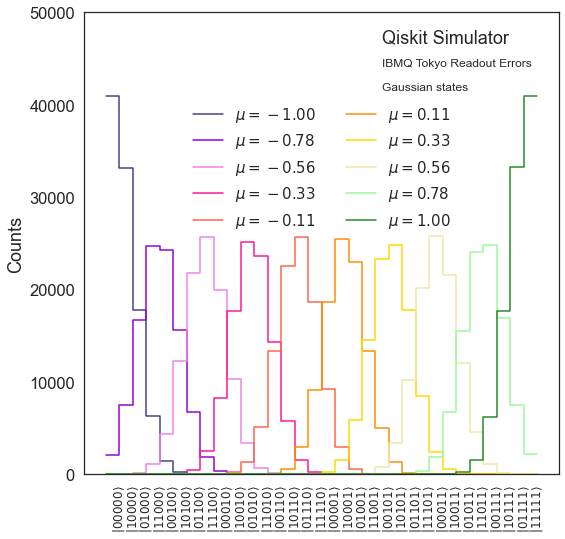

In [102]:
bincenters_r = np.array(xvals)+0.5
sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
gs = GridSpec(1, 1)
ax1 = plt.subplot(gs[0])
ax1.set_xticklabels( () )

colors = ["darkslateblue","darkviolet","violet","deeppink","tomato","darkorange","gold","palegoldenrod","palegreen","forestgreen","mediumturquoise","darkcyan","black","black","black","black","black"]

ii=0
for mean in np.linspace(-1,1,10):
    Gaussian_state = QuantumCircuit(q,c) 
    Gaussian_state.initialize(NormalDistribution(5,mu=mean,sigma=0.1,low=-1,high=1).probabilities**0.5, q)
    Gaussian_state.append(measure2_r, nqubitarray_r, nqubitarray_r) 
    result = execute(Gaussian_state, simulator_r, shots=100000).result()
    gaussian_counts = result.get_counts()
    measured_test_gaussian = np.zeros(2**nqubits_r)
    for i in range(2**nqubits_r):
        binnumber_initial = mybin(i,nqubits_r,0)
        measured_test_gaussian[i] = 0
        if (binnumber_initial in gaussian_counts):
            measured_test_gaussian[i]+=gaussian_counts[binnumber_initial]

    mybincenters = np.linspace(-0.5,31.5,33)
    plt.step(mybincenters,myre(measured_test_gaussian),color=colors[ii],label="$\mu="+"%0.2f" % mean+"$")
    ii+=1

_=plt.xticks(xvals,xlabs0,rotation='vertical',fontsize=10)
plt.ylabel('Counts')
plt.ylim([0,2.*max(truth_test_r)])
plt.legend(bbox_to_anchor = [0.8, 0.5],fontsize=15,frameon=False, ncol=2)
_=plt.text(20., 26000*1.8, "Qiskit Simulator", fontsize=18)
_=plt.text(20., 26000*1.7, "IBMQ Tokyo Readout Errors", fontsize=12)
_=plt.text(20., 26000*1.6, "Gaussian states", fontsize=12)

plt.ylim([0,50000])
_=plt.xticks(xvals,xlabs,rotation='vertical',fontsize=12)
plt.savefig("GaussianState_shift.pdf",bbox_inches='tight')

In [160]:
#Sweep Gaussian from right to left

rerun = False
resave = False

if (rerun):

    mean_vals2 = []
    sigma_vals2 = []
    emean_vals2 = []
    esigma_vals2 = []
    x_vals2 = []
    
    mean_valsG = []
    sigma_valsG = []
    emean_valsG = []
    esigma_valsG = []
    x_valsG = []  
    
    mean_vals = []
    sigma_vals = []
    emean_vals = []
    esigma_vals = []
    x_vals = []    
    
    for mean in np.linspace(-1,1,10):
        Gaussian_state = QuantumCircuit(q,c) 
        Gaussian_state.initialize(NormalDistribution(5,mu=mean,sigma=0.1,low=-1,high=1).probabilities**0.5, q)
        Gaussian_state.append(measure2_r, nqubitarray_r, nqubitarray_r) 
        result = execute(Gaussian_state, simulator_r, shots=100000).result()
        gaussian_counts = result.get_counts()
        measured_test_gaussian = np.zeros(2**nqubits_r)
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            measured_test_gaussian[i] = 0
            if (binnumber_initial in gaussian_counts):
                measured_test_gaussian[i]+=gaussian_counts[binnumber_initial]
        #Gaussian_state_modified,swapmap1_gaussian = rebalance_method2(Gaussian_state,measured_test_gaussian,5)
        mean_hold,sigma_hold,vals_hold = mean_stat_uncert(Gaussian_state,[0,0,0,0,0],N=1000,nshots=10000)
        print(mean,mean_hold,sigma_hold)
        x_vals2+=[mean]
        mean_vals2+=[mean_hold]
        sigma_vals2+=[sigma_hold]
        emean_vals2+=[mean_stat(vals_hold)]
        esigma_vals2+=[std_stat(vals_hold)]        
        
        mean_holdG,sigma_holdG,vals_holdG = mean_stat_uncert_Google(Gaussian_state)
        x_valsG+=[vals_holdG]
        mean_valsG+=[mean_holdG]
        sigma_valsG+=[sigma_holdG]            
        emean_valsG+=[mean_stat(vals_holdG)]
        esigma_valsG+=[std_stat(vals_holdG)]         
        
    for mean in np.linspace(-1,1,10):
        Gaussian_state = QuantumCircuit(q,c) 
        Gaussian_state.initialize(NormalDistribution(5,mu=mean,sigma=0.1,low=-1,high=1).probabilities**0.5, q)
        Gaussian_state.append(measure2_r, nqubitarray_r, nqubitarray_r) 
        result = execute(Gaussian_state, simulator_r, shots=100000).result()
        gaussian_counts = result.get_counts()
        measured_test_gaussian = np.zeros(2**nqubits_r)
        for i in range(2**nqubits_r):
            binnumber_initial = mybin(i,nqubits_r,0)
            measured_test_gaussian[i] = 0
            if (binnumber_initial in gaussian_counts):
                measured_test_gaussian[i]+=gaussian_counts[binnumber_initial]
        Gaussian_state_modified,swapmap1_gaussian = rebalance_method2(Gaussian_state,measured_test_gaussian,5)
        mean_hold,sigma_hold,vals_hold = mean_stat_uncert(Gaussian_state_modified,swapmap1_gaussian,N=1000,nshots=10000)
        print(mean,swapmap1_gaussian,mean_hold,sigma_hold)
        x_vals+=[mean]
        mean_vals+=[mean_hold]
        sigma_vals+=[sigma_hold]  
        emean_vals+=[mean_stat(vals_hold)]
        esigma_vals+=[std_stat(vals_hold)]  

    if (resave):
        np.save("files/Gaussianmean_vals2",mean_vals2)
        np.save("files/Gaussiansigma_vals2",sigma_vals2)
        np.save("files/Gaussianemean_vals2",emean_vals2)
        np.save("files/Gaussianesigma_vals2",esigma_vals2)
        np.save("files/Gaussianx_vals2",x_vals2)

        np.save("files/Gaussianmean_valsG",mean_valsG)
        np.save("files/Gaussiansigma_valsG",sigma_valsG)
        np.save("files/Gaussianemean_valsG",emean_valsG)
        np.save("files/Gaussianesigma_valsG",esigma_valsG)
        np.save("files/Gaussianx_valsG",x_valsG)        
        
        np.save("files/Gaussianmean_vals",mean_vals)
        np.save("files/Gaussiansigma_vals",sigma_vals)
        np.save("files/Gaussianemean_vals",emean_vals)
        np.save("files/Gaussianesigma_vals",esigma_vals)
        np.save("files/Gaussianx_vals",x_vals)

else:
    mean_vals2 = np.load("files/Gaussianmean_vals2.npy")
    sigma_vals2 = np.load("files/Gaussiansigma_vals2.npy")
    emean_vals2 = np.load("files/Gaussianemean_vals2.npy")
    esigma_vals2 = np.load("files/Gaussianesigma_vals2.npy")
    x_vals2 = np.load("files/Gaussianx_vals2.npy")

    mean_valsG = np.load("files/Gaussianmean_valsG.npy")
    sigma_valsG = np.load("files/Gaussiansigma_valsG.npy")
    emean_valsG = np.load("files/Gaussianemean_valsG.npy")
    esigma_valsG = np.load("files/Gaussianesigma_valsG.npy")
    x_valsG = np.load("files/Gaussianx_valsG.npy")    
    
    mean_vals = np.load("files/Gaussianmean_vals.npy")
    sigma_vals = np.load("files/Gaussiansigma_vals.npy")
    emean_vals = np.load("files/Gaussianemean_vals.npy")
    esigma_vals = np.load("files/Gaussianesigma_vals.npy")
    x_vals = np.load("files/Gaussianx_vals.npy")

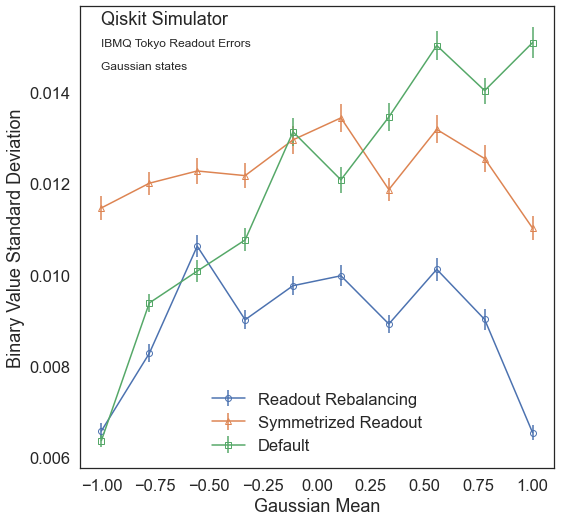

In [164]:
sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
gs = GridSpec(1, 1)

plt.errorbar(x_vals,sigma_vals,yerr=esigma_vals,label="Readout Rebalancing",marker='o',fillstyle='none')
plt.errorbar(x_vals,sigma_valsG,yerr=esigma_valsG,label="Symmetrized Readout",marker='^',fillstyle='none')
plt.errorbar(x_vals,sigma_vals2,yerr=esigma_vals2,label="Default",marker='s',fillstyle='none')

plt.legend(frameon=False,loc="lower center")

_=plt.text(-1, 0.0155, "Qiskit Simulator", fontsize=18)
_=plt.text(-1, 0.015, "IBMQ Tokyo Readout Errors", fontsize=12)
_=plt.text(-1, 0.0145, "Gaussian states", fontsize=12)

plt.xlabel("Gaussian Mean")
plt.ylabel("Binary Value Standard Deviation")
plt.savefig("std_mean.pdf",bbox_inches='tight')

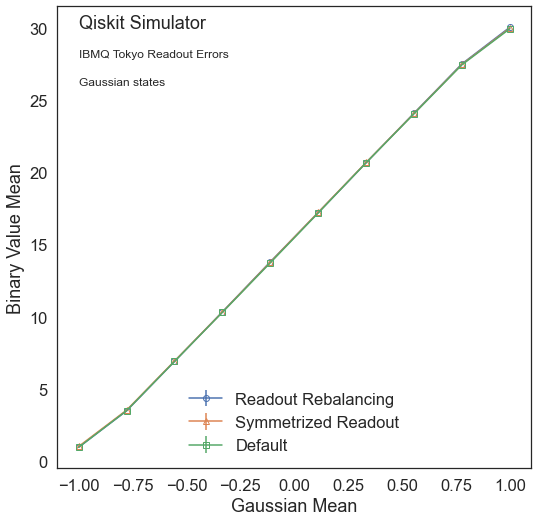

In [163]:
sns.set_style("white")
f = plt.figure(figsize=(8.5, 8.5))
gs = GridSpec(1, 1)

plt.errorbar(x_vals,mean_vals,yerr=emean_vals,label="Readout Rebalancing",marker='o',fillstyle='none')
plt.errorbar(x_vals,mean_valsG,yerr=emean_valsG,label="Symmetrized Readout",marker='^',fillstyle='none')
plt.errorbar(x_vals,mean_vals2,yerr=emean_vals2,label="Default",marker='s',fillstyle='none')

plt.legend(frameon=False,loc="lower center")

_=plt.text(-1, 30, "Qiskit Simulator", fontsize=18)
_=plt.text(-1, 28, "IBMQ Tokyo Readout Errors", fontsize=12)
_=plt.text(-1, 26, "Gaussian states", fontsize=12)
plt.xlabel("Gaussian Mean")
plt.ylabel("Binary Value Mean")
plt.savefig("mean_mean.pdf",bbox_inches='tight')

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table